# Height GWAS

This is GWAS analysis for tz2014 data to find snps associate with height

## 1. Import

In [108]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from scipy import stats

import matplotlib.pyplot as plt

#from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [174]:
from sklearn.ensemble import RandomForestRegressor

## 2. Load Data

In [2]:
(tz_bim,tz_fam,tz_bed) = read_plink('ddat/crowdAI/all2964/bin_final_strand')

Mapping files: 100%|██████████| 3/3 [00:03<00:00,  1.87s/it]


In [3]:
tz_maf =  pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)

In [ ]:
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
all_meta.columns=['ID', 'height', 'ChipID', 'nationality', 'gender']

## 3. Clean Data

In [ ]:
def select_snp(arr):
    if arr[0]==0 or arr[0]==26:
        return 0
    elif arr[4]<0.05 or arr[4]>0.95:
        return 0
    elif arr[2]=='A' and arr[3]=='T':
        return 0
    elif arr[2]=='T' and arr[3]=='A':
        return 0
    elif arr[2]=='G' and arr[3]=='C':
        return 0
    elif arr[2]=='C' and arr[3]=='G':
        return 0
    else:
        return 1

In [6]:
def plink_slice(p,pb=None,pf=None):
    """
    p: list of bim, fam, bed
    pb: index of bim
    pf: index of fam
    """
    (bim,fam,bed)=p
    if pb:
        bim = bim.iloc[pb]
        bed = bed[pb,:]
    if pf:
        fam = fam.iloc[pf]
        bed = bed[:,pf]
    return(bim,fam,bed)

In [4]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]

In [7]:
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_met a.ChipID)]
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),list(tz_maf_new.index),tz_sample_index)

## 4. GWAS Model

### 4.1 Linear GWAS

In [9]:
tz_meta=all_meta.loc[tz_sub[1].iid,]

In [10]:
x = tz_meta.gender.values
y = tz_meta.height.values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

y_residual = y-(intercept + slope*x)

In [12]:
tz_snps=tz_sub[2].compute()

In [28]:
nan_result = []
snp_result={}
for i in range(tz_snps.shape[0]):
    x = tz_snps[i]
    nan_idx = np.isnan(x)
    x[nan_idx]=-1
    nan_result.append(sum(nan_idx))
    snp_result[i]=list(stats.linregress(x,y_residual))


In [66]:
sum(tz_snps[2]==-1)

1

In [84]:
nan_result[0:10]

[0, 17, 1, 15, 1, 2, 0, 9, 2, 2]

In [30]:
len(nan_result)

684066

In [32]:
tmp=pd.DataFrame(snp_result)

In [34]:
snp_result[0]

[-0.16789886434731258,
 0.29802506827721426,
 -0.013613881848849981,
 0.4756992579309186,
 0.23537176159523104]

In [41]:
snp_pv_idx=np.argsort(tmp.iloc[3,])

In [48]:
snps_gwas=tmp.iloc[:,snp_pv_idx].T

In [45]:
tz_sub_new=plink_slice(tz_sub,list(snp_pv_idx))

In [50]:
snps_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']

In [54]:
tz_sub_new[0].head()

,chrom,snp,cm,pos,a0,a1,i
197781,4,rs1712374,0.0,82154710,C,T,197781
197775,4,rs710839,0.0,82134787,C,T,197775
197780,4,rs710841,0.0,82149831,T,C,197780
697818,18,kgp5403113,0.0,20647291,G,A,697818
197784,4,rs1901568,0.0,82187030,C,T,197784


In [53]:
snps_gwas.index = list(tz_sub_new[0].snp)

In [55]:
snps_gwas.to_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender.csv')

### 4.1 Plot

In [94]:
top10=tz_sub_new[2][0:10].compute()

In [106]:
tz_sub_new[0][0:20]

,chrom,snp,cm,pos,a0,a1,i
197781,4,rs1712374,0.0,82154710,C,T,197781
197775,4,rs710839,0.0,82134787,C,T,197775
197780,4,rs710841,0.0,82149831,T,C,197780
697818,18,kgp5403113,0.0,20647291,G,A,697818
197784,4,rs1901568,0.0,82187030,C,T,197784
197785,4,rs6535239,0.0,82192994,A,G,197785
218628,4,kgp10482756,0.0,175484746,C,A,218628
197793,4,kgp11672887,0.0,82279666,A,G,197793
218618,4,rs2555674,0.0,175466101,A,C,218618
197796,4,rs11723619,0.0,82287755,T,G,197796


In [101]:
top10 = pd.DataFrame(top10.T,columns=list(tz_sub_new[0].snp[0:10]))

In [105]:
top10.corr()

,rs1712374,rs710839,rs710841,kgp5403113,rs1901568,rs6535239,kgp10482756,kgp11672887,rs2555674,rs11723619
rs1712374,1.000000,0.984850,0.983655,0.019790,0.984336,0.982408,-0.014081,0.914578,-0.011929,0.914351
rs710839,0.984850,1.000000,0.968301,0.019204,0.969205,0.967289,-0.011230,0.898893,-0.012872,0.898596
rs710841,0.983655,0.968301,1.000000,0.023652,0.968079,0.966192,-0.013440,0.899931,-0.009088,0.897596
kgp5403113,0.019790,0.019204,0.023652,1.000000,0.019104,0.017286,0.012571,0.022021,0.004516,0.019105
rs1901568,0.984336,0.969205,0.968079,0.019104,1.000000,0.998051,-0.011746,0.929586,-0.009870,0.929442
rs6535239,0.982408,0.967289,0.966192,0.017286,0.998051,1.000000,-0.011361,0.931677,-0.009636,0.931550
kgp10482756,-0.014081,-0.011230,-0.013440,0.012571,-0.011746,-0.011361,1.000000,-0.017393,0.751476,-0.016550
kgp11672887,0.914578,0.898893,0.899931,0.022021,0.929586,0.931677,-0.017393,1.000000,-0.011440,0.986561
rs2555674,-0.011929,-0.012872,-0.009088,0.004516,-0.009870,-0.009636,0.751476,-0.011440,1.000000,-0.010962
rs11723619,0.914351,0.898596,0.897596,0.019105,0.929442,0.931550,-0.016550,0.986561,-0.010962,1.000000


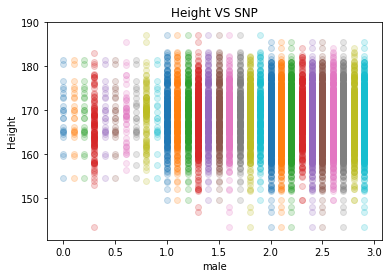

In [151]:
for i in range(top10.shape[1]):
    one_snp = top10.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==1)], tz_meta.height[tz_meta.gender==1],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('male');
    plt.ylabel('Height');

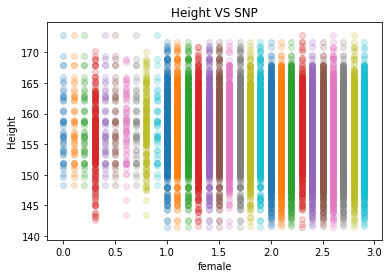

In [150]:
for i in range(top10.shape[1]):
    one_snp = top10.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==2)], tz_meta.height[tz_meta.gender==2],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('female');
    plt.ylabel('Height');

### 4.2 Linear GWAS for Female

In [131]:
tz_f_meta=tz_meta[tz_meta.gender==2]
tz_f_idx = list(tz_meta.gender==2)

In [134]:
snp_result_f={}
for i in range(tz_snps.shape[0]):
    x = tz_snps[i][tz_f_idx]
    snp_result_f[i]=list(stats.linregress(x,tz_f_meta.height.values))

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [136]:
snps_f_gwas=pd.DataFrame(snp_result_f)
snp_pv_f_idx=np.argsort(snps_f_gwas.iloc[3,])
snps_f_gwas=snps_f_gwas.iloc[:,snp_pv_f_idx].T
snps_f_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
tz_sub_f_new=plink_slice(tz_sub,list(snp_pv_f_idx))
snps_f_gwas.index = list(tz_sub_f_new[0].snp)

In [141]:
snps_f_gwas.to_csv(TMP_PATH/'SNPs_GWAS_TZ_Female.csv')

### 4.2 Plot for Female

In [142]:
top10_f=tz_sub_f_new[2][0:10].compute()
top10_f = pd.DataFrame(top10_f.T,columns=list(tz_sub_f_new[0].snp[0:10]))

In [143]:
tz_sub_f_new[0][0:10]

,chrom,snp,cm,pos,a0,a1,i
464037,10,rs1763895,0.0,61303675,T,C,464037
454444,10,rs2488114,0.0,18309005,G,A,454444
95182,2,rs6715320,0.0,128510982,A,G,95182
472251,10,kgp9954016,0.0,89814969,T,C,472251
472252,10,rs545138,0.0,89817829,T,C,472252
464032,10,rs1763885,0.0,61294973,C,A,464032
65565,2,kgp11805143,0.0,11167641,C,A,65565
65564,2,rs2357887,0.0,11165291,G,T,65564
69643,2,rs10202934,0.0,25359254,C,T,69643
541101,12,rs3816804,0.0,56680745,T,C,541101


In [145]:
top10_f.corr()

,rs1763895,rs2488114,rs6715320,kgp9954016,rs545138,rs1763885,kgp11805143,rs2357887,rs10202934,rs3816804
rs1763895,1.000000,0.030503,-0.001233,0.001079,-0.002102,0.912174,-0.028587,-0.027064,0.006479,-0.004087
rs2488114,0.030503,1.000000,-0.016714,-0.002131,-0.000964,0.030847,0.015527,0.008941,-0.013930,0.002423
rs6715320,-0.001233,-0.016714,1.000000,-0.019133,-0.021496,-0.002337,-0.025941,-0.021339,-0.016402,-0.015494
kgp9954016,0.001079,-0.002131,-0.019133,1.000000,0.996574,-0.007758,0.014901,0.006428,0.005095,-0.008906
rs545138,-0.002102,-0.000964,-0.021496,0.996574,1.000000,-0.008201,0.013776,0.005290,0.006004,-0.008937
rs1763885,0.912174,0.030847,-0.002337,-0.007758,-0.008201,1.000000,-0.025667,-0.026643,0.005565,-0.015384
kgp11805143,-0.028587,0.015527,-0.025941,0.014901,0.013776,-0.025667,1.000000,0.946473,0.000576,0.006099
rs2357887,-0.027064,0.008941,-0.021339,0.006428,0.005290,-0.026643,0.946473,1.000000,-0.001905,0.003132
rs10202934,0.006479,-0.013930,-0.016402,0.005095,0.006004,0.005565,0.000576,-0.001905,1.000000,-0.014234
rs3816804,-0.004087,0.002423,-0.015494,-0.008906,-0.008937,-0.015384,0.006099,0.003132,-0.014234,1.000000


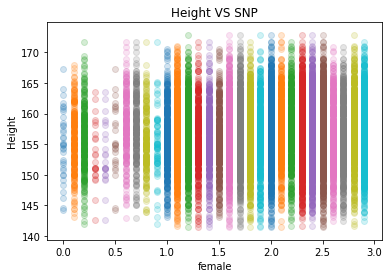

In [148]:
for i in range(top10_f.shape[1]):
    one_snp = top10_f.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==2)], tz_meta.height[tz_meta.gender==2],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('female');
    plt.ylabel('Height');

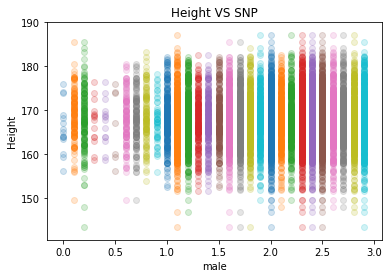

In [149]:
for i in range(top10_f.shape[1]):
    one_snp = top10_f.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==1)], tz_meta.height[tz_meta.gender==1],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('male');
    plt.ylabel('Height');

### 4.3 Linear GWAS for Male

In [152]:
tz_m_meta=tz_meta[tz_meta.gender==1]
tz_m_idx = list(tz_meta.gender==1)

In [153]:
snp_result_m={}
for i in range(tz_snps.shape[0]):
    x = tz_snps[i][tz_m_idx]
    snp_result_m[i]=list(stats.linregress(x,tz_m_meta.height.values))

In [154]:
snps_m_gwas=pd.DataFrame(snp_result_m)
snp_pv_m_idx=np.argsort(snps_m_gwas.iloc[3,])
snps_m_gwas=snps_m_gwas.iloc[:,snp_pv_m_idx].T
snps_m_gwas.columns=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
tz_sub_m_new=plink_slice(tz_sub,list(snp_pv_m_idx))
snps_m_gwas.index = list(tz_sub_m_new[0].snp)

In [155]:
snps_m_gwas.to_csv(TMP_PATH/'SNPs_GWAS_TZ_Male.csv')

### 4.3 Plot for Male

In [156]:
top10_m=tz_sub_m_new[2][0:10].compute()
top10_m = pd.DataFrame(top10_m.T,columns=list(tz_sub_m_new[0].snp[0:10]))

In [157]:
tz_sub_m_new[0][0:10]

,chrom,snp,cm,pos,a0,a1,i
670679,17,rs4790702,0.0,4665454,G,A,670679
785155,23,rs4986610,0.0,71209899,G,A,785155
785156,23,rs12011214,0.0,71210482,T,C,785156
680005,17,rs7216471,0.0,41805259,A,G,680005
785157,23,kgp22746254,0.0,71219960,A,G,785157
412144,9,rs4562386,0.0,4429166,C,T,412144
221750,4,rs17074039,0.0,183689445,C,T,221750
697818,18,kgp5403113,0.0,20647291,G,A,697818
170419,3,rs4555533,0.0,176592004,T,C,170419
170121,3,rs16826153,0.0,175403065,A,G,170121


In [158]:
top10_m.corr()

,rs4790702,rs4986610,rs12011214,rs7216471,kgp22746254,rs4562386,rs17074039,kgp5403113,rs4555533,rs16826153
rs4790702,1.000000,0.002849,0.004290,-0.019394,0.002760,-0.014946,0.048265,0.000829,0.013811,-0.055638
rs4986610,0.002849,1.000000,0.996979,0.011933,0.996377,0.017241,-0.016229,0.007412,-0.010933,-0.001744
rs12011214,0.004290,0.996979,1.000000,0.012659,0.993350,0.016772,-0.016590,0.009641,-0.010800,-0.005138
rs7216471,-0.019394,0.011933,0.012659,1.000000,0.012685,0.007008,0.013281,-0.046330,-0.033447,0.011342
kgp22746254,0.002760,0.996377,0.993350,0.012685,1.000000,0.016459,-0.014112,0.005736,-0.012880,-0.000668
rs4562386,-0.014946,0.017241,0.016772,0.007008,0.016459,1.000000,-0.034511,-0.015903,-0.023469,-0.024336
rs17074039,0.048265,-0.016229,-0.016590,0.013281,-0.014112,-0.034511,1.000000,-0.035577,0.009620,0.036803
kgp5403113,0.000829,0.007412,0.009641,-0.046330,0.005736,-0.015903,-0.035577,1.000000,0.036421,0.032685
rs4555533,0.013811,-0.010933,-0.010800,-0.033447,-0.012880,-0.023469,0.009620,0.036421,1.000000,0.013473
rs16826153,-0.055638,-0.001744,-0.005138,0.011342,-0.000668,-0.024336,0.036803,0.032685,0.013473,1.000000


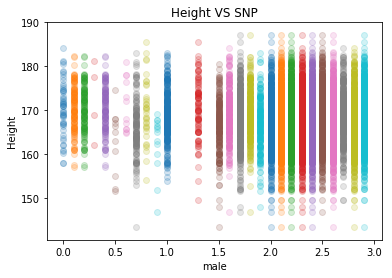

In [159]:
for i in range(top10_m.shape[1]):
    one_snp = top10_m.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==1)], tz_meta.height[tz_meta.gender==1],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('male');
    plt.ylabel('Height');

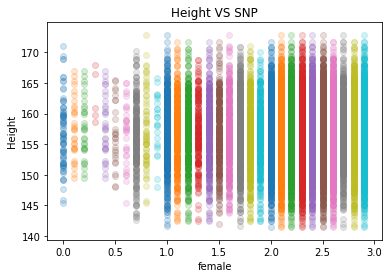

In [160]:
for i in range(top10_m.shape[1]):
    one_snp = top10_m.iloc[:,i]+i*0.1
    plt.scatter(one_snp[list(tz_meta.gender==2)], tz_meta.height[tz_meta.gender==2],alpha=0.2);
    plt.title('Height VS SNP');
    plt.xlabel('female');
    plt.ylabel('Height');

## 5. Prediction

In [161]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from sklearn import linear_model

In [215]:
def topsnp_model(m,X,y,val_idx,topn=[500, 200, 100, 50, 20, 10]):
    score_list={}
    for n in topn: 
        var_idx = list(range(n))
        ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))

        ml = m
        ml.fit(trn, y_trn)
        
        preds = np.clip(ml.predict(trn),145,195)
        preds1 = np.clip(ml.predict(val),145,195)
        f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')
        ax1.scatter(y_trn,preds, marker='o')
        ax2.scatter(y_val,preds1, marker='o')
        plt.title(n);
        plt.show()
           
        score_list[n]=(ml.score(trn, y_trn), ml.score(val, y_val))
    return score_list

### 5.1.1 Linear Prediction for Female

In [216]:
samp_size=len(tz_f_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
f_val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)

1758 1406


In [ ]:
X=pd.DataFrame(tz_sub_f_new[2][0:500].compute().T)
X= X[tz_f_idx]
X.fillna(-1,inplace=True)

In [ ]:
tz_f_model = topsnp_model(m=linear_model.LinearRegression(),X=X,y=tz_f_meta.height,val_idx=f_val_idx)

In [ ]:
tz_f_model

### 5.1.2 RandomForest Prediction for Female

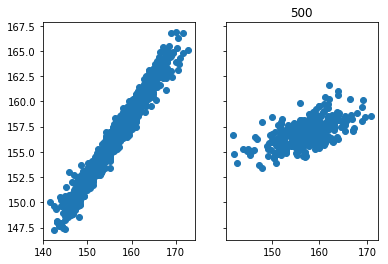

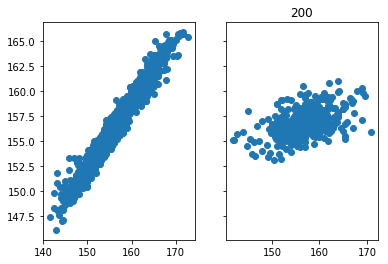

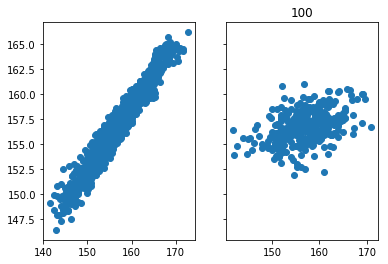

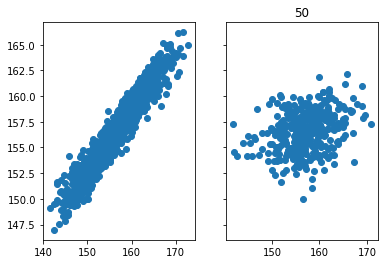

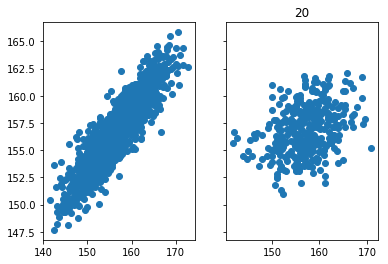

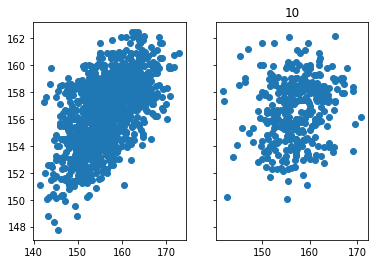

In [175]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
tz_f_rf = topsnp_model(m=m,X=X,y=tz_f_meta.height,val_idx=f_val_idx)

In [176]:
tz_f_rf

{500: (0.8586194911953893, 0.23866194690169584),
 200: (0.8506733970196342, 0.18741838739862626),
 100: (0.8429934573164968, 0.1629613714947853),
 50: (0.8068369120074015, 0.07308283393174797),
 20: (0.7022629880870587, 0.07820246178880297),
 10: (0.30136454809563784, -0.06410987348852193)}

### 5.1.3 LogisticRegression Prediction for Female

In [190]:
f50 = np.percentile(tz_f_meta.height,50)
f50

156.8

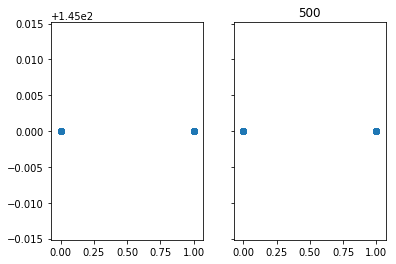

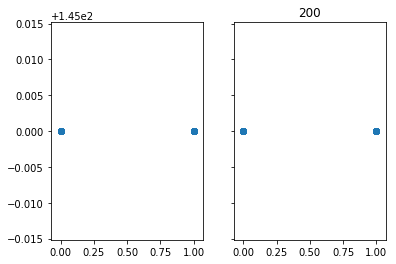

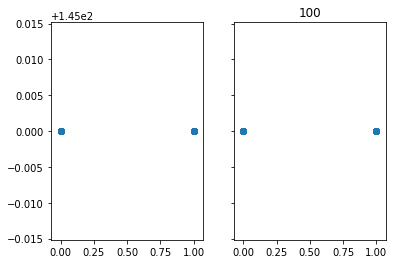

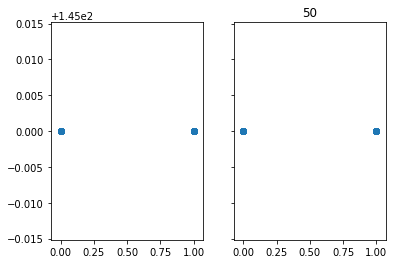

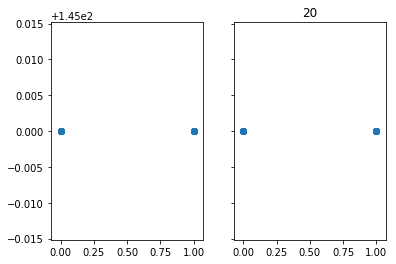

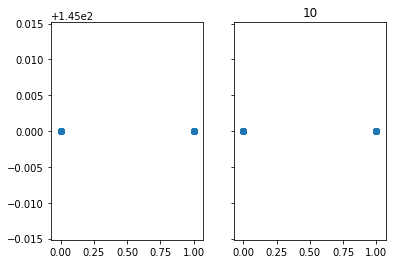

In [192]:
tz_f_lg = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=(tz_f_meta.height > f50).astype(int),val_idx=f_val_idx)

In [193]:
tz_f_lg

{500: (0.903271692745377, 0.6875),
 200: (0.7802275960170697, 0.6875),
 100: (0.7091038406827881, 0.6818181818181818),
 50: (0.6735419630156472, 0.6363636363636364),
 20: (0.6372688477951636, 0.6193181818181818),
 10: (0.6194879089615932, 0.6107954545454546)}

for classification, top 200 snps is enough. 

### 5.1.4 KNN Classifier for Female

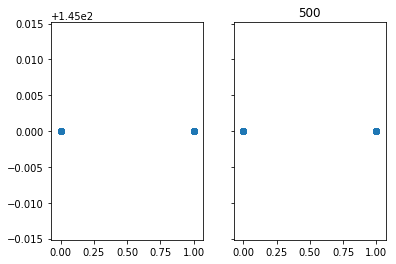

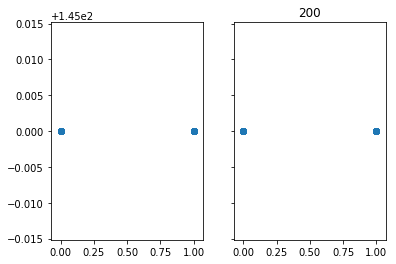

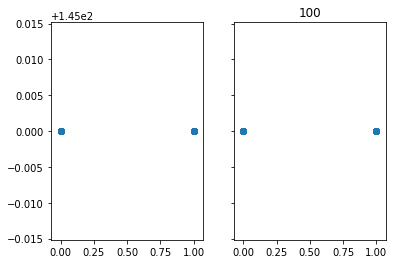

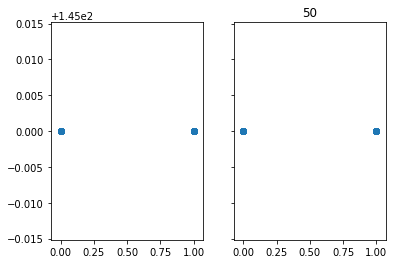

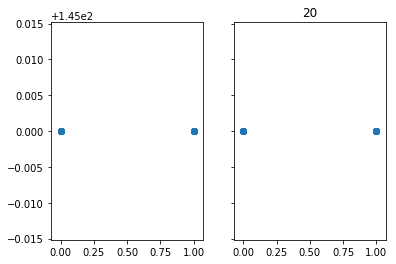

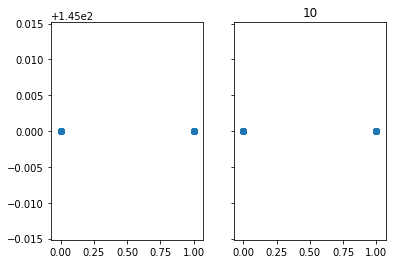

In [194]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)
tz_f_knn = topsnp_model(m=knn,X=X,y=(tz_f_meta.height > f50).astype(int),val_idx=f_val_idx)

In [195]:
tz_f_knn

{500: (0.8243243243243243, 0.5198863636363636),
 200: (0.7894736842105263, 0.5113636363636364),
 100: (0.7788051209103841, 0.5028409090909091),
 50: (0.7844950213371266, 0.5625),
 20: (0.7667140825035562, 0.5568181818181818),
 10: (0.6586059743954481, 0.5142045454545454)}

### 5.1.5 Mutiple LogisticRegression for Female

In [199]:
def y_triple(x,mh,ml,fh,fl,g):
    if g==1:
        if x>mh:
            return 1
        elif x<ml:
            return -1
        else:
            return 0
    elif g==2:
        if x>fh:
            return 1
        elif x<fl:
            return -1
        else:
            return 0
    else:
        print('error')

m25 = np.percentile(tz_meta.height.loc[list(tz_meta.gender==1)],25)
f25 = np.percentile(tz_meta.height.loc[list(tz_meta.gender==2)],25)
m75 = np.percentile(tz_meta.height.loc[list(tz_meta.gender==1)],75)
f75 = np.percentile(tz_meta.height.loc[list(tz_meta.gender==2)],75)
print(m25,f25,m75,f75)
yt= [y_triple(x,m75,m25,f75,f25,tz_f_meta.gender.iloc[i]) for i,x in enumerate(tz_f_meta.height)]

164.0 153.1 172.0 160.4


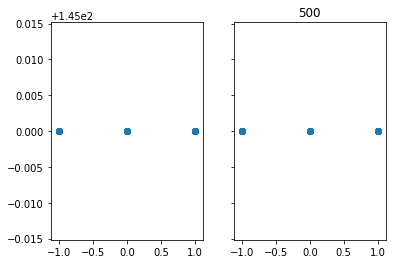

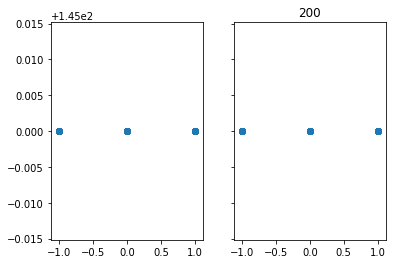

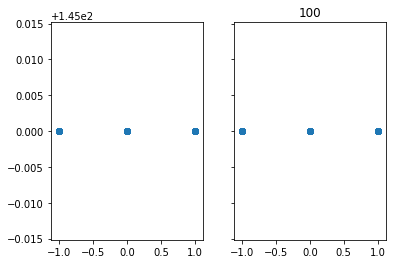

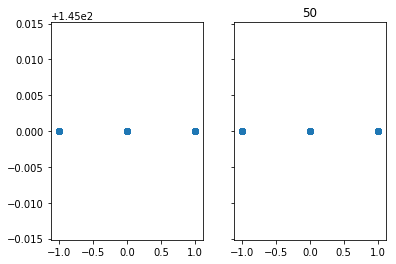

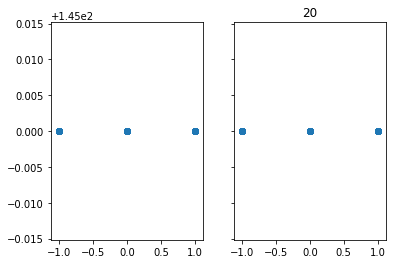

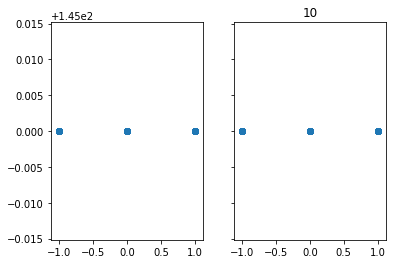

In [201]:
tz_f_lg_triple = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=yt,val_idx=f_val_idx)

In [202]:
tz_f_lg_triple

{500: (0.8918918918918919, 0.5681818181818182),
 200: (0.7005689900426743, 0.5539772727272727),
 100: (0.6137980085348507, 0.5369318181818182),
 50: (0.55049786628734, 0.5710227272727273),
 20: (0.5206258890469416, 0.5596590909090909),
 10: (0.5071123755334281, 0.5653409090909091)}

### 5.1.6 Distance Prediction for Female

In [212]:
def cosine_similarity(vecx, vecy):
    norm = np.sqrt(np.dot(vecx, vecx))* np.sqrt(np.dot(vecy, vecy))
    return np.dot(vecx, vecy) / (norm + 1e-10)

def compute(vecx,vecys):
    n =len(vecys)
    scores = [0] * n
    for i in range(n):
        scores[i] = cosine_similarity(vecx, vecys[i])
    return scores


def predict(vecx,vecys,y,topk=20):
    scores = compute(vecx, vecys)
    sorted_idx = np.argsort(scores)[::-1][:topk]
    return [(y[i], scores[i]) for i in sorted_idx]

def distance(X,y,val_idx,topn=[500, 200, 100, 50, 20, 10]):
    score_list={}
    for n in topn: 
        var_idx = list(range(n))
        ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.iloc[:,var_idx].values, np.array(y))
        preds=[]
        for i in range(len(val)):
            preds.append(predict(val[i],trn,y_trn,topk=1)[0])
           
        
        plt.scatter(y_val,[x for x,_ in preds], marker='o')
        plt.show()
           
        score_list[n]=(y_val, preds)
    return score_list

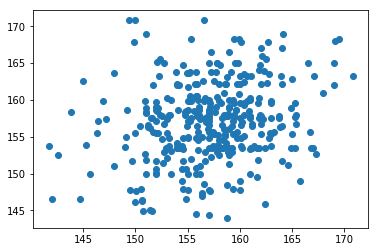

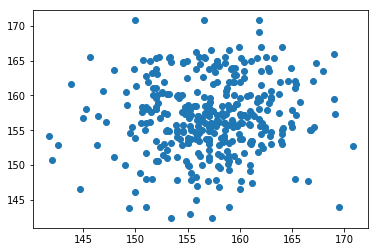

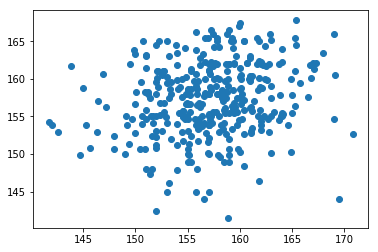

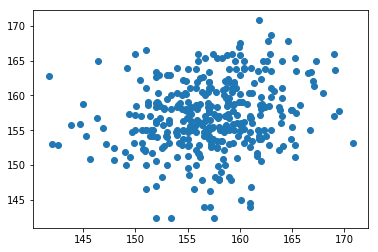

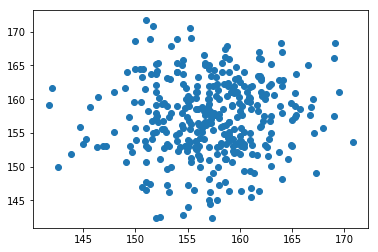

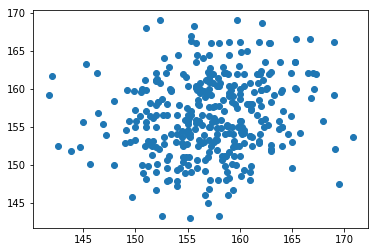

In [213]:
tz_f_dist = distance(X=X,y=tz_f_meta.height,val_idx=f_val_idx)

### 5.2.1 Linear Prediction for Male

In [177]:
samp_size=len(tz_m_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
m_val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)

989 791


In [178]:
X=pd.DataFrame(tz_sub_m_new[2][0:500].compute().T)
X= X[tz_m_idx]
X.fillna(-1,inplace=True)

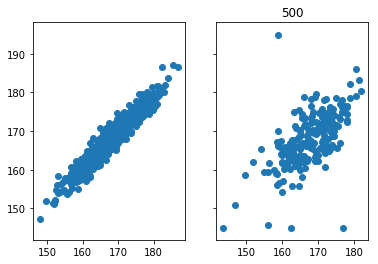

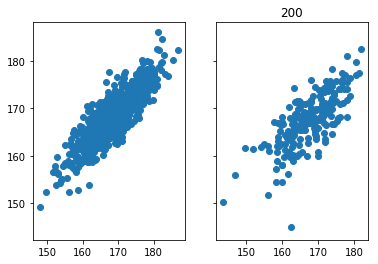

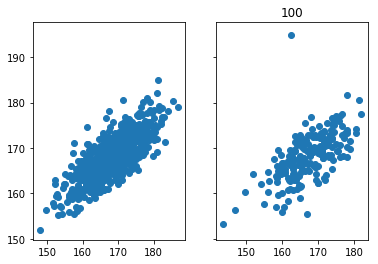

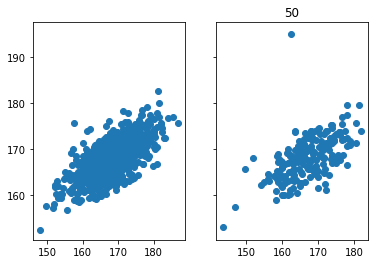

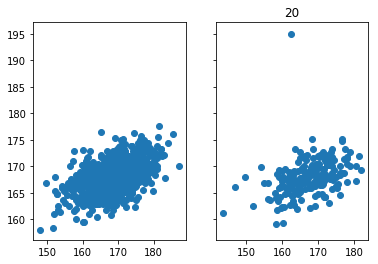

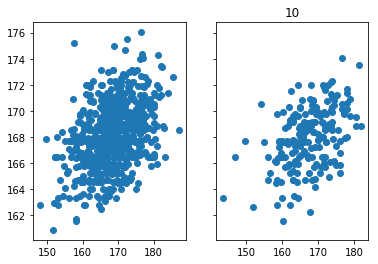

In [179]:
tz_m_lr = topsnp_model(m=linear_model.LinearRegression(),X=X,y=tz_m_meta.height,val_idx=m_val_idx)

In [180]:
tz_m_lr

{500: (0.9176386778183468, -5.694007040426464e+22),
 200: (0.7397732944236421, -9.046963633622215e+23),
 100: (0.584410692258847, -2.9699141956950116e+21),
 50: (0.4591464137818436, -4.722632555548071e+21),
 20: (0.25495503999048186, -1.5793421646276113e+26),
 10: (0.14724136823868927, 0.17943808670145356)}

### 5.2.2 RandomForest Prediction for Male

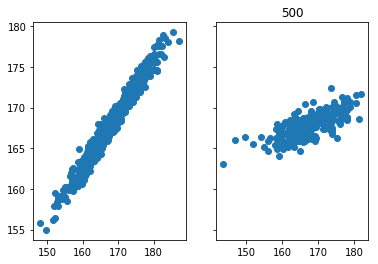

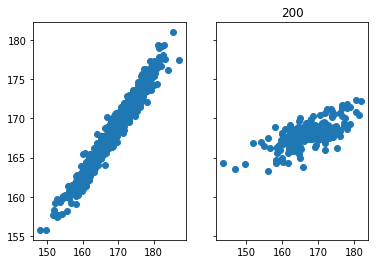

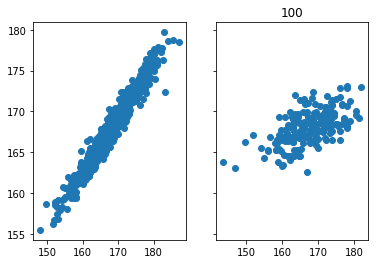

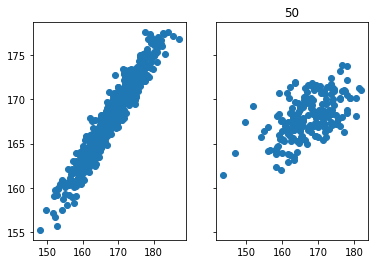

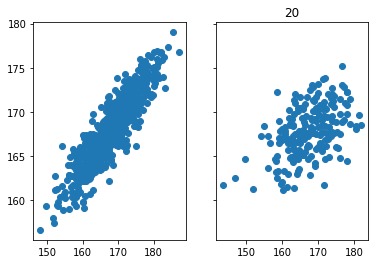

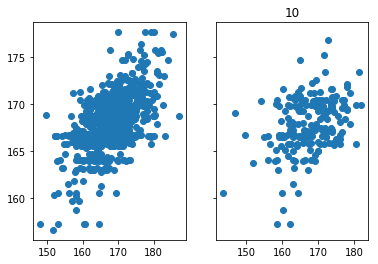

In [181]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
tz_m_rf = topsnp_model(m=m,X=X,y=tz_m_meta.height,val_idx=m_val_idx)

In [182]:
tz_m_rf

{500: (0.8750523609094677, 0.28035596031461774),
 200: (0.8715178373720448, 0.28101443819971506),
 100: (0.8645413942060054, 0.27272357522269364),
 50: (0.8366137115101564, 0.26082871171261734),
 20: (0.7092852277191344, 0.22109386793442698),
 10: (0.3101404381744296, 0.12939205374747542)}